In [1]:
import re
import random
import torch
from torch import nn
import collections
from torch.nn import functional as F

In [2]:
# 1.序列模型
from d2l import torch as d2l
from IPython import display
import matplotlib.pyplot as plt  #@save
#@save
def use_svg_display():
    # 使用 svg 格式在 jupyter 中绘图
    display.set_matplotlib_formats('svg')
#@save
def set_figsize(figsize = (3.5, 2.5)):
    use_svg_display()
    d2l.plt.rcParams['figure.figsize'] = figsize
#@save
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴。"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
#@save
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, 
         xlim=None, ylim=None, xscale='linear', yscale='linear', 
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点。"""
    if legend is None:
        legend = []
    set_figsize(figsize)
    axes = axes if axes else d2l.plt.gca()
    # 如果 `X` 有⼀个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or 
                isinstance(X, list) and not hasattr(X[0], "__len__"))
    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

In [3]:
from torch.utils import data
#@save
def load_array(data_arrays, batch_size, is_train = True): 
    """构造一个 Pytorch 数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(
        dataset, batch_size, shuffle = is_train)

In [4]:
class Accumulator:  #@save
    """在 n 个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上的模型损失"""
    metric = d2l.Accumulator(2)  # 损失的总和，样本数量
    for x, y in data_iter:
        out = net(x)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
import time
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """启动计时器"""
        self.tik = time.time()
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累积时间"""
        return np.array(self.times).cumsum().tolist()

In [6]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [7]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel = None, ylabel = None, 
                 legend = None, xlim = None, ylim = None, 
                 xscale = 'linear', yscale = 'linear', 
                 fmts = ('-', 'm--', 'g-.', 'r:'), 
                 nrows = 1, ncols = 1,  figsize = (3.5, 2.5)):
        """增量的绘制多条线"""
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize = figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, 
                                                xscale, yscale, legend)
        self.x, self.y, self.fmts = None, None, fmts
    def add(self, x, y):
        """向表中添加多个数据点"""
        if not hasattr(y, '__len__'):
            y = [y]
        n = len(y)
        if not hasattr(x, '__len__'):
            x = [x] * n
        if not self.x:
            self.x = [[] for _ in range(n)]
        if not self.y:
            self.y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.x[i].append(a)
                self.y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.x, self.y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait = True)

In [8]:
DATA_HUB = dict()  #@save
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/' #@save

In [9]:
# 下⾯的 download 函数⽤来下载数据集，将数据集缓存在本地⽬录（默认情况下为../data）中，并返回下载⽂件的名称
import os
import requests
import hashlib
def download(name, cache_dir=os.path.join('C:/Users/hasee/Desktop/cvtf', 'data')): #@save
    """下载⼀个DATA_HUB中的⽂件，返回本地⽂件名。"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok = True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname # Hit cache
    print(f'正在从{url}下载{fname}...') 
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [10]:
# 读取数据集(将文本作为字符串加载到内存中)
DATA_HUB['time_machine'] = (
    DATA_URL + 'timemachine.txt', 
    '090b5e7e70c295757f55df93cb0a180b9691891a')
def read_time_machine(): #@save
    """Load the time machine dataset into a list of text lines."""
    with open(download('time_machine'), 'r') as f:
        lines = f.readlines()  # 读取每一行
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() 
            for line in lines]

In [11]:
# 标记化(将字符串拆分成标记)
def tokenize(lines, token='word'): #@save
    """将⽂本⾏拆分为单词或字符标记。"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知令牌类型：' + token)

In [106]:
#@save
class Vocab:
    """文本词表"""
    def __init__(self, tokens = None, min_freq = 0, 
                 reserved_tokens = None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self.token_freqs = sorted(
            counter.items(), key = lambda x:x[1], reverse = True)
        # 未知标记的索引为零
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [
            token for token, freq in self.token_freqs 
            if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1
    def __len__(self):
        return len(self.idx_to_token)
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
# 建立一个词汇表，将拆分的标记映射到数字索引
def count_corpus(tokens):  #@save
    """统计标记的频率"""
    # 这里 tokens 是 1D 或者 2D 列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将标记列表展平成使用标记填充的一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [13]:
# 将文本转换为数字索引序列
def load_corpus_time_machine(max_tokens = -1):  #@save
    """返回时光机器数据集的标记索引列表和词汇表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    """因为时光机器数据集中的每一个文本行，不一定是一个句子或者一个段落"""
    """所以将所有文本行展开到一个列表中"""
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

In [14]:
# 读取长序列数据
# 随机采样
#@save
def seq_data_iter_random(corpus, batch_size, num_steps):
    """使用随机抽样生成一个小批量序列"""
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为 num_steps 的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, 
                                 num_steps))
    # 在随机抽样的迭代过程中
    # 来自两个相邻的，随机的，小批量的子序列比一定在原始序列上相邻
    random.shuffle(initial_indices)
    def data(pos):
        # 返回 pos 位置开始的长度为 num_steps 的序列
        return corpus[pos:pos + num_steps]
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        initial_indices_per_batch = initial_indices[
            i:i + batch_size]
        x = [data(j) for j in initial_indices_per_batch]
        y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(x), torch.tensor(y)

In [15]:
# 顺序分区
#@save
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """使用顺序分区生成一个小批量序列"""
    """从随机偏移量开始划分序列"""
    offset = random.randint(0, num_steps)
    num_tokens = (
        (len(corpus) - offset - 1) // batch_size) * batch_size
    xs = torch.tensor(corpus[offset:offset + num_tokens])
    ys = torch.tensor(corpus[offset + 1:offset + 1 + num_tokens])
    xs, ys = xs.reshape(batch_size, -1), ys.reshape(batch_size, -1)
    num_batches = xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        x = xs[:, i:i + num_steps]
        y = ys[:, i:i + num_steps]
        yield x, y

In [16]:
# 我们将上面的两个采样函数包装到一个类中，以便稍后可以将其用作数据迭代器
#@save
class SeqDataLoader:
    """加载序列数据的迭代器"""
    def __init__(
        self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(
            max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps
    def __iter__(self):
        return self.data_iter_fn(
            self.corpus, self.batch_size, self.num_steps)

In [17]:
# 返回数据迭代器和词汇表，类似于 load_data_fashion_mnist 
#@save
def load_data_time_machine(
    batch_size, num_steps, use_random_iter = False, 
    max_tokens = 10000):
    """返回时光机器数据集的迭代器和词汇表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [18]:
def try_gpu(i = 0):  #@save
    """如果存在，则返回 gpu(i)，否则返回 cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f"cuda:{i}")
    return torch.device('cpu')

In [19]:
#@save
class RNNModelScratch:
    """从零开始实现的循环神经网络"""
    def __init__(self, vocab_size, num_hiddens, 
                 device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
    def __call__(self, x, state):
        x = F.one_hot(x.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(x, state, self.params)
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [20]:
# 预测
#@save
def predict_ch8(prefix, num_preds, net, vocab, device):
    """在 prefix 后面生成新字符"""
    state = net.begin_state(batch_size = 1, device = device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda:torch.tensor(
        [outputs[-1]], device = device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测 num_prds 步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim = 1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [21]:
# 梯度剪裁
#@save
def grad_clipping(net, theta):
    """剪裁梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [22]:
# 训练
#@save
def train_epoch_ch8(
    net, train_iter, loss, updater, device, use_random_iter):
    """训练模型一个迭代周期"""
    state, timer = None, Timer()
    metric = Accumulator(2)  # 训练损失之和，标记数量
    for x, y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(
                batch_size = x.shape[0], device = device)
        else:
            if isinstance(
                net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = y.T.reshape(-1)
        x, y = x.to(device), y.to(device)
        y_hat, state = net(x, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size = 1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [23]:
#@save
def train_ch8(net, train_iter, vocab, 
              lr, num_epochs, device, use_random_iter = False):
    """训练模型"""
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel = 'epoch', ylabel = 'perplexity', 
                        legend = ['train'], xlim = [10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size:sgd(net.params, lr, batch_size)
    predict = lambda prefix:predict_ch8(
        prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f"困惑度：{ppl:.2f}, {speed:.2f}标记/秒, {str(device)}")
    print(predict('time traveller'))
    print(predict('traveller'))

In [24]:
#@save
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(
                self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(
                self.num_hiddens * 2, self.vocab_size)
    def forward(self, inputs, state):
        x = F.one_hot(inputs.T.long(), self.vocab_size)
        x = x.to(torch.float32)
        # 全连接层首先将 y 的形状改为 时间步数 * 批量大小，隐藏单元
        y, state = self.rnn(x, state)
        # 输出形状为 时间步数 * 批量大小，此表大小
        output = self.linear(y.reshape((-1, y.shape[-1])))
        return output, state
    def begin_state(self, device, batch_size = 1):
        if not isinstance(self.rnn, nn.LSTM):
            return torch.zeros(
                (self.num_directions * self.rnn.num_layers, 
                 batch_size, self.num_hiddens), device = device)
        else:
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers, 
                batch_size, self.num_hiddens), device = device), 
                    torch.zeros(
                        (self.num_directions * self.rnn.num_layers,
                         batch_size, self.num_hiddens), 
                        device = device))

In [25]:
# ---------------------------------------------------------

In [26]:
# 1. 门控循环单元 (GRU)
import torch
from torch import nn

In [27]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [28]:
# 初始化模型参数
#@save
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.randn(size = shape, device = device) * 0.01
    def three():
        return (normal(
            (num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)), 
                torch.zeros(num_hiddens, device = device))
    w_xz, w_hz, b_z = three()
    w_xr, w_hr, b_r = three()
    w_xh, w_hh, b_h = three()
    w_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device = device)
    params = [
        w_xz, w_hz, b_z, w_xr, w_hr, b_r, \
        w_xh, w_hh, b_h, w_hq, b_q]
    for param in params:
        param.requires_grad_(True)
        return params

In [29]:
# 定义模型
#@save
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device = device),)

In [30]:
#@save
def gru(inputs, state, params):
    w_xz, w_hz, b_z, w_xr, w_hr, b_r, w_xh, \
    w_hh, b_h, w_hq, b_q = params
    (H,) = state
    outputs = []
    for x in inputs:
        z = torch.sigmoid((x @ w_xz) + (H @ w_hz) + b_z)
        r = torch.sigmoid((x @ w_xr) + (H @ w_hr) + b_r)
        H_tilda = torch.tanh((x @ w_xh) + ((r * H) @ w_hh) + b_h)
        H = z * H + (1 - z) * H_tilda
        y = H @ w_hq + b_q
        outputs.append(y)
    return torch.cat(outputs, dim = 0), (H,)

In [31]:
# 训练与预测
x = torch.arange(10).reshape(2, 5)
vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()
num_epochs, lr = 500, 1
model = RNNModelScratch(
    len(vocab), num_hiddens, device, get_params, init_gru_state, gru)

In [32]:
# train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [33]:
# 简洁实现
import math
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)

困惑度：1.04, 264314.04标记/秒, cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


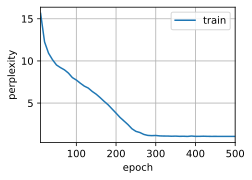

In [34]:
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [35]:
# 2.长短期记忆网络(LSTM)
import torch
from torch import nn

In [36]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [37]:
# 初始化模型参数
#@save
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.randn(size = shape, device = device) * 0.01
    def three():
        return (normal(
            (num_inputs, num_hiddens)), normal(
            (num_hiddens, num_hiddens)), torch.zeros(
            num_hiddens, device = device))
    w_xi, w_hi, b_i = three()
    w_xf, w_hf, b_f = three()
    w_xo, w_ho, b_o = three()
    w_xc, w_hc, b_c = three()
    w_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_hiddens, device = device)
    params = [
        w_xi, w_hi, b_i, w_xf, w_hf, b_f, w_xo, w_ho,  \
        b_o, w_xc, w_hc, b_c, w_hq, b_q]
    # 附加梯度
    for param in params:
        param.requires_grad_(True)
    return params

In [38]:
# 定义模型
#@save
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device = device), 
            torch.zeros((batch_size, num_steps), device = device))

In [39]:
#@save
def lstm(inputs, state, params):
    [w_xi, w_hi, b_i, w_xf, w_hf, b_f, w_xo, w_ho, \
     b_o, w_xc, w_hc, b_c, w_hq, b_q] = params
    (H, c) = state
    outputs = []
    for x in inputs:
        i = torch.sigmoid((x @ w_xi) + (H @ w_hi) + b_i)
        f = torch.sigmoid((x @ w_xf) + (H @ w_hf) + b_f)
        o = torch.sigmoid((x @ w_xo) + (H @ w_ho) + b_o)
        c_tilda = torch.tanh((x @ w_xc) + (H @ w_hc) + b_c)
        c = f * c + i * c_tilda
        H = o * torch.tanh(c)
        y = (H @ w_hq) + b_q
        outputs.append(y)
    return torch.cat(outputs, dim = 0), (H, c)

In [40]:
# 训练与预测
vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()
num_epochs, lr = 500, 1
model = RNNModelScratch(
    len(vocab), num_hiddens, device, get_lstm_params, 
    init_lstm_state, lstm)

In [41]:
# train_ch8(model, train_iter, vocab, lr, num_epochs, device)

困惑度：1.06, 221285.78标记/秒, cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


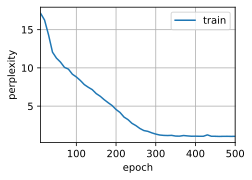

In [42]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [43]:
# 3.深度循环神经网络

In [44]:
# 简洁实现
import torch
from torch import nn

In [45]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [46]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)

In [47]:
# 训练与预测
num_epochs, lr = 500, 2

困惑度：1.03, 134369.85标记/秒, cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


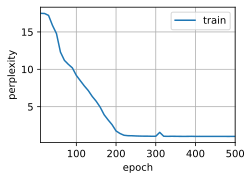

In [48]:
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [49]:
# 4.双向循环神经网络
import torch
from torch import nn

In [50]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(
    batch_size, num_steps)
device = try_gpu()

In [51]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size

In [52]:
lstm_layer = nn.LSTM(
    num_inputs, num_hiddens, num_layers, bidirectional = True)

In [53]:
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)

In [54]:
# 训练模型
num_epochs, lr = 500, 1

困惑度：1.11, 69761.03标记/秒, cuda:0
time travellerererererererererererererererererererererererererer
travellerererererererererererererererererererererererererer


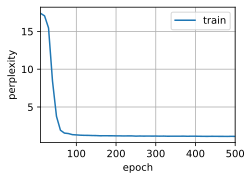

In [55]:
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [105]:
# 5.机器翻译与数据集
import os
import torch
import zipfile
import tarfile
from d2l import torch as d2l
#@save
def download_extract(name, folder = None):
    """下载并解压了 zip/tar 文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有 zip/tar 文件可以压缩。'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir
def download_all():  #@save
    """下载 DATA_HUB 中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [57]:
# 下载和预处理数据集
#@save
DATA_HUB['fra-eng'] = (DATA_URL + 'fra-eng.zip', 
                       '94646ad1522d915e7b0f9296181140edcf86a4f5')

In [58]:
#@save
def read_data_nmt():
    """载入 英语-法语 数据及"""
    data_dir = download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding="utf-8") as f:
        return f.read()

In [59]:
raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [60]:
#@save
def preprocess_nmt(text):
    """预处理 英语-法语 数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    """使用空格代替不间断空格"""
    """使用小写代替大写"""
    text = text.replace(
        '\u202f', ' ').replace('\xa0', ' ').lower()
    """ \xa0: 表示的是空格字符 """
    """在单词和标点符号之间插入空格"""
    out = [
        ' ' + char if i > 0 and no_space(char, text[i - 1]) 
        else char for i, char in enumerate(text)]
    return ''.join(out)

In [61]:
text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [62]:
# 标记化
#@save
def tokenize_nmt(text, num_examples = None):
    """标记化 英语-法语 数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

In [63]:
source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

C:\Users\hasee\AppData\Local\Temp/ipykernel_13968/2042258718.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


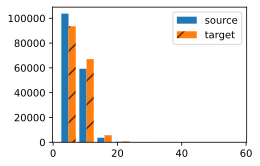

In [64]:
set_figsize()
_, _, patches = plt.hist(
    [[len(l) for l in source], [len(l) for l in target]], 
    label = ['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
plt.legend(loc = 'upper right')

In [65]:
# 词汇表
src_vocab = Vocab(source, min_freq = 2, reserved_tokens = [
    '<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [66]:
# 加载数据集
#@save
def truncate_pad(line, num_steps, padding_token):
    """截断或者填充文本"""
    if len(line) > num_steps:
        return line[:num_sreps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  

In [67]:
src_vocab['<pad>']

1

In [68]:
truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [69]:
src_vocab[source[0]]

[47, 4]

In [70]:
source[0]

['go', '.']

In [71]:
# 将⽂本序列转换成小批量数据集⽤于训练
#@save
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor(
        [truncate_pad(l, num_steps, vocab['<pad>']) 
         for l in lines])
    valid_len = (
        array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

In [72]:
# 训练模型
#@save
def load_data_nmt(
    batch_size, num_steps, num_examples = 600):
    """返回数据集的迭代器和词汇表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(
        source, min_freq = 2, reserved_tokens = [
            '<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(
        target, min_freq = 2, reserved_tokens = [
            '<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(
        source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(
        target, src_vocab, num_steps)
    data_arrays = (
        src_array, src_valid_len, 
        tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [73]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(
    batch_size = 2, num_steps = 8)

In [74]:
for x, x_valid_len, y, y_valid_len in train_iter:
    print('x: ', x.type(torch.int32))
    print('valid lengths for x: ', x_valid_len)
    print('y: ', y.type(torch.int32))
    print('valid lengths for y: ', y_valid_len)
    break

x:  tensor([[ 13,  20,   5,   3,   1,   1,   1,   1],
        [106, 107,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
valid lengths for x:  tensor([4, 4])
y:  tensor([[0, 0, 0, 0, 0, 0, 5, 3],
        [0, 0, 0, 4, 3, 1, 1, 1]], dtype=torch.int32)
valid lengths for y:  tensor([8, 5])


In [3]:
# 6.编码器-解码器结构
# 编码器
import torch
from torch import nn
#@save
class Encoder(nn.Module):
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
    def forward(self, x, *args):
        raise NotImplementedError

In [4]:
# 解码器
#@save
class Decoder(nn.Module):
    def __init_(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
    def init_state(self, enc_outputs, *args):
        raise NotImplementedError
    def forward(self, x, state):
        raise NotImplementedError

In [77]:
# 合并编码器和解码器
#@save
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, enc_x, dec_x, *args):
        enc_outputs = self.encoder(enc_x, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_x, dec_state)

In [78]:
# 7.序列到序列模型学习(seq2seq)
x = torch.randn(2, 3, 5)
x.permute(2, 0, 1).size(), x.permute(0, 1, 2).size()

(torch.Size([5, 2, 3]), torch.Size([2, 3, 5]))

In [79]:
x.size(1)

3

In [80]:
x = torch.arange(6).reshape(2, 3)
x, x[None, :]

(tensor([[0, 1, 2],
         [3, 4, 5]]),
 tensor([[[0, 1, 2],
          [3, 4, 5]]]))

In [81]:
a = torch.arange(2).reshape(2, )
a

tensor([0, 1])

In [82]:
mask = x[None, :] <= a[:, None]
mask

tensor([[[ True, False, False],
         [False, False, False]]])

In [83]:
import collections
import math
import torch
from torch import nn

In [84]:
# 编码器
#@save
class Seq2SeqEncoder(Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(
        self, vocab_size, embed_size, num_hiddens, num_layers, 
        dropout = 0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)  
        # 嵌入层来获得输入序列中每个标记的特征向量
        self.rnn = nn.GRU(
            embed_size, num_hiddens, num_layers, dropout = dropout)
    def forward(self, x, *args):
        # 输出 x 的形状: batch_size, num_steps, embed_size
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        output, state = self.rnn(x)
        # output 的形状: num_steps, batch_size, num_hiddens
        # state 的形状: num_layers, batch_size, num_hiddens
        return output, state

In [85]:
encoder = Seq2SeqEncoder(
    vocab_size = 10, embed_size = 8, num_hiddens = 16, num_layers = 2)
encoder.eval()
x = torch.zeros((4, 7), dtype = torch.long)

In [86]:
output, state = encoder(x)

In [87]:
output.shape, state.shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

In [5]:
# 解码器
#@save
class Seq2SeqDecoder(Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(
        self, vocab_size, embed_size, num_hiddens, 
        num_layers, dropout = 0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, 
            num_layers, dropout = dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]  # 返回 state
    def forward(self, x, state):
        # 输出 x 的形状: batch_size, num_steps, embed_size
        x = self.embedding(x).permute(1, 0, 2)
        context = state[-1].repeat(x.shape[0], 1, 1)
        x_and_context = torch.cat((x, context), 2)
        output, state = self.rnn(x_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output.size = batch_size, num_steps, vocab_size
        # state[o].shape = num_layers, batch_size, num_hiddens
        return output, state

In [89]:
decoder = Seq2SeqDecoder(
    vocab_size = 10, embed_size = 8, num_hiddens = 16, num_layers = 2)
decoder.eval()
state = decoder.init_state(encoder(x))
output, state = decoder(x, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [107]:
# 损失函数
#@save
def sequence_mask(x, valid_len, value = 0):
    """在序列中屏蔽不相关的项"""
    maxlen = x.size(1)
    mask = torch.arange(
        maxlen, dtype = torch.float32, device =\
        x.device)[None,:] < valid_len[:, None]
    x[~mask] = value
    return x

In [91]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(x, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [92]:
x = torch.ones(2, 4, 4)
sequence_mask(x, torch.tensor([1, 3]), value = 10)

tensor([[[ 1.,  1.,  1.,  1.],
         [10., 10., 10., 10.],
         [10., 10., 10., 10.],
         [10., 10., 10., 10.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [10., 10., 10., 10.]]])

In [93]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带屏蔽的 softmax 的交叉熵损失"""
    # pred.shape = batch_size, num_steps, vocab_size
    # label.shape = batch_size, num_steps
    # valid_len.shape = (batch_size, )
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(
            MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim = 1)
        return weighted_loss

In [94]:
loss = MaskedSoftmaxCELoss()

In [95]:
"""
我们可以指定这些序列的有效⻓度分别为 4、2 和 0
第⼀个序列的损失应为第⼆个序列的 2 倍，而第三个序列的损失应为 0
"""
loss(
    torch.ones(3, 4, 100), torch.ones((3, 4), dtype = torch.long), 
    torch.tensor([4, 2, 0]))

tensor([4.6052, 2.3026, 0.0000])

In [96]:
# 训练
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if 'weight' in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = Animator(
        xlabel = 'epoch', ylabel = 'loss', xlim = [10, num_epochs])
    for epoch in range(num_epochs):
        timer = Timer()
        metric = Accumulator(2)  # 训练损失之和，标记数量
        for batch in data_iter:
            x, x_valid_len, y, y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor(
                [tgt_vocab['<bos>']] * y.shape[0], 
                device = device).reshape(-1, 1)
            dec_input = torch.cat([bos, y[:, :-1]], 1)  # 教师强制
            y_hat, _ = net(x, dec_input, x_valid_len)
            l = loss(y_hat, y, y_valid_len)
            l.sum().backward()
            grad_clipping(net, 1)
            num_tokens = y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1], ))
    print(f"loss: {metric[0] / metric[1]:.3f},\
          {metric[1] / timer.stop():.3f} tokens/sec, on {str(device)}")

In [97]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, try_gpu()

In [98]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

In [99]:
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)

loss: 0.008,          10674.988 tokens/sec, on cuda:0


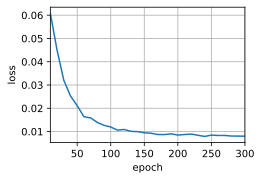

In [100]:
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [101]:
# 预测
#@save
def predict_seq2seq(
    net, src_sentence, src_vocab, num_steps, device, 
    save_attention_weights = False):
    """序列到序列模型的预测"""
    net.eval()
    src_tokens = src_vocab[
        src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device = device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    """添加批量轴"""
    enc_x = torch.unsquence(
        torch.tensor(src_tokens, dtype = torch.long, device = device), 
        dim = 0)
    enc_outputs = net.encoder(enc_x, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    """添加批量轴"""
    dec_x = torch.unsquence(torch.tensor(
        [tgt_vocab['<bos>']], dtype = torch.long, device = device), 
                            dim = 0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        y, dec_state = net.decoder(dec_x, dec_state)
        """我们使用具有预测最高可能性的标记，作为解码在下一时间步的输入"""
        dec_y = y.argmax(dim = 2)
        pred = dec_x.squeeze(dim = 0).type(torch.int32).item()
        """保存注意力权重"""
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        """一旦序列结束标记被预测，输出序列的生成就完成了"""
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [102]:
# 预测序列的评估
#@save
def bleu(pred_seq,label_seq, k):
    """计算 BLEU """
    pred_tokens, label_tokens = pres_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i : i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i : i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i : i + n])] -= 1
        score *= math.pow(
            num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [103]:
cuda_device = torch.device('cpu')
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [104]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, cuda_device)
    print(
        f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.